# Teste com a parte dos vídeos dos alunos da ufla da base de dados TODO

## Criação dos modelos

In [1]:
from nn4_small2_v1 import create_model as create_nn4
from vgg_face import create_model as create_vgg
from facenet import InceptionResNetV1 as create_facenet

Using TensorFlow backend.
/home/italo/eFaceRecon/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/italo/eFaceRecon/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/italo/eFaceRecon/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/italo/eFaceRecon/env/lib/python3.7/sit

In [2]:
nn4_small2 = create_nn4()
vgg_face = create_vgg()
facenet = create_facenet()
nn4_small2.load_weights('weights/nn4.small2.v1.h5')
vgg_face.load_weights('weights/vgg_face_weights.h5')
facenet.load_weights('weights/facenet.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Carregar a base de dados

In [3]:
import numpy as np
import os.path
from person import Person


def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        if os.path.exists(os.path.join(path, i) + "/videos"):
            for f in os.listdir(os.path.join(path, i) + "/videos"):
                metadata.append(Person(path, i, f, vp_exists="videos"))
    return np.array(metadata)

videos_mt = load_metadata('dataset/ufla')

## Detecção e Alinhamento

In [4]:
import cv2
import dlib
from image_align import align_image

face_detector = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")


def load_video(path):
    obj = cv2.VideoCapture(path)
    success = 1
    image_list = []
    counter = 0
    while success:
        counter += 1
        # O OpenCV carrega as imagens com os canais de cores
        # na ordem BGR. Então precisamos invertê-las
        success, img = obj.read()
        if success and (counter % 15 == 0):
            image_list.append(img[...,::-1])
    return image_list

videos_96 = []
videos_160 = []
videos_224 = []
qts_frames = []
for i,v in enumerate(videos_mt):
    image_list = load_video(v.image_path())
    imgs_96 = []
    imgs_160 = []
    imgs_224 = []
    counter = 0
    qt_aligned = 0
    for img in image_list:
        counter += 1
        gray =  cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        bounding_boxes = face_detector.detectMultiScale(gray, 1.3, 1)
        aligned = None
        for (x, y, w, h) in bounding_boxes:
            aligned = align_image(img, dlib.rectangle(x,y,x+w,y+h), 224)
        if not (aligned is None):
            imgs_96.append(cv2.resize(aligned, (96, 96)))
            imgs_160.append(cv2.resize(aligned, (160, 160)))
            imgs_224.append(aligned)
            # escala os valores RGB para o intervalo [0,1]
            imgs_96[qt_aligned] = (imgs_96[qt_aligned] / 255. ).astype(np.float32)
            imgs_160[qt_aligned] = ((imgs_160[qt_aligned] / 127.5) - 1.).astype(np.float32)
            imgs_224[qt_aligned] = ((imgs_224[qt_aligned] / 127.5) - 1.).astype(np.float32)
            qt_aligned += 1
    qts_frames.append(len(imgs_96))
    videos_96.append(imgs_96)
    videos_160.append(imgs_160)
    videos_224.append(imgs_224)
print("Quantidade de frames restantes para cada vídeo = ", qts_frames)
    
    

Quantidade de frames restantes para cada vídeo =  [16, 30, 27, 26, 6, 22, 29, 11, 14, 43, 40, 39]


## Extração de Atributos

In [5]:
# TODO deu certo! Agora é extrair as features

def l2_normalize(x):
    return x / np.sqrt(np.sum(np.multiply(x, x)))

v_embedded_nn4 = []
v_embedded_facenet = []
v_embedded_vgg = []

for qt_frame in qts_frames:
    embedded_nn4 = np.zeros((qt_frame, 128))
    v_embedded_nn4.append(embedded_nn4)
    embedded_facenet = np.zeros((qt_frame, 128))
    v_embedded_facenet.append(embedded_facenet)
    embedded_vgg = np.zeros((qt_frame, 2622))
    v_embedded_vgg.append(embedded_vgg)


for i, v in enumerate(videos_mt):
    for j in range(len(v_embedded_nn4[i])):
        v_embedded_nn4[i][j] = nn4_small2.predict(np.expand_dims(videos_96[i][j], axis=0))[0]
        v_embedded_facenet[i][j] = l2_normalize(facenet.predict(np.expand_dims(videos_160[i][j], axis=0))[0,:])
        v_embedded_vgg[i][j] = vgg_face.predict(np.expand_dims(videos_224[i][j], axis=0))[0,:]
    # grava no vetor persons o seu embeddign vecor
    v.embedded_nn4 = v_embedded_nn4[i]
    v.embedded_facenet = v_embedded_facenet[i]
    v.embedded_vgg = v_embedded_vgg[i]


## Diferentes distâncias

In [6]:
def dist_cos(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))
 
def dist_eucl(source_representation, test_representation):
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

## Classificação

In [7]:
# TODO agrupar corretamente os frames por vídeo

from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost.sklearn import XGBClassifier
import math
import matplotlib.pyplot as plt
from scipy.stats import mode
from collections import defaultdict

def format_float(n, decimals=2):
    multiplier = 10 ** decimals
    new_f = math.floor(n*multiplier + 0.5) / multiplier
    return "{:.2f}".format(new_f).replace('.',',')


# string para gravar os resultados de classificação em csv
class_result = "RNC;Classificador;Precisão (%);Revocação (%);Medida-F (%);Percentual de acertos\n"


# Para plotar o gráfico
# data_for_graph[0] = precisão
# data_for_graph[1] = revocação
# data_for_graph[2] = medida-F
# data_for_graph[3] = percentual de acertos

targets = np.array([v.name for v in videos_mt])
data_for_graph = None
encoder = LabelEncoder()
encoder.fit(targets)

# Transformar as classes em números
y = encoder.transform(targets)

# Criar os índices para teste
qt_by_name = defaultdict(list)
for tgt in list(set(targets)):
    qt_by_name[tgt] = 0


# Função para agrupar os resultados para cada vídeo
def group_res(indexes, y_calc):
    resultado = defaultdict(list)
    for i in range(len(indexes)):
        if resultado[indexes[i]] is None:
            resultado[indexes[i]] = []
        resultado[indexes[i]].append(y_calc[i])
    output = []
    for key in resultado:
        resultado[key] = mode(resultado[key]).mode[0]
        output.append(resultado[key])
    return np.array(output)
        



train_indexes = np.full(len(v_embedded_nn4), False)

for i in range(len(train_indexes)):
    if(qt_by_name[videos_mt[i].name] != 2):
        train_indexes[i] = True
        qt_by_name[videos_mt[i].name] += 1
        
        
def write_results(y_true, y_pred, method, neural_net):
    global class_result
    global data_for_graph
    
    precisao = precision_score(y_true, y_pred, average='macro') * 100.0
    data_for_graph[0].append(precisao)
    revocacao = recall_score(y_true, y_pred, average='macro') * 100.0
    data_for_graph[1].append(revocacao)
    medida_f = f1_score(y_true, y_pred, average='macro') * 100.0
    data_for_graph[2].append(medida_f)
    percentual_acertos = accuracy_score(y_true, y_pred) * 100.0
    data_for_graph[3].append(medida_f)
    class_result += neural_net + ";" + method + ";" + format_float(precisao) + ";" + format_float(revocacao) + \
            ";" + format_float(medida_f) + ";" + format_float(percentual_acertos) + "\n"


def classify_and_report(neural_net):
    global data_for_graph
    global X_train
    global video_groupper_test
    data_for_graph = [[],[],[],[]]
    
    # Construindo os classificadores.
    knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
    svm = LinearSVC()
    decision_tree = DecisionTreeClassifier(random_state=0, min_samples_split=5)
    random_forest = RandomForestClassifier(random_state=0, min_samples_split=5, n_estimators=60)
    adaboost = AdaBoostClassifier(random_state=0, n_estimators=20, base_estimator=DecisionTreeClassifier(max_depth=5))
    naive_bayes = GaussianNB()
    xgboost = XGBClassifier(random_state=0, objective='multi:softmax', num_class=4, n_estimators=50, max_depth=5)
    
    
    knn.fit(X_train, y_train)
    decision_tree.fit(X_train, y_train)
    random_forest.fit(X_train, y_train)
    adaboost.fit(X_train, y_train)
    naive_bayes.fit(X_train, y_train)
    svm.fit(X_train, y_train)
    xgboost.fit(X_train, y_train)


    y_knn = group_res(video_groupper_test,knn.predict(X_test))
    y_svm = group_res(video_groupper_test,svm.predict(X_test))
    y_decision_tree = group_res(video_groupper_test,decision_tree.predict(X_test))
    y_random_forest = group_res(video_groupper_test,random_forest.predict(X_test))
    y_adaboost = group_res(video_groupper_test,adaboost.predict(X_test))
    y_naive_bayes = group_res(video_groupper_test,naive_bayes.predict(X_test))
    y_xgboost = group_res(video_groupper_test,xgboost.predict(X_test).astype(np.int))
    
    print('y_naive_bayes = ', y_naive_bayes)
    print('y_xgboost = ', y_xgboost)
    
    # Gerar o relatório de classificação
    class_knn = classification_report(y_test, y_knn, target_names=encoder.classes_)
    write_results(y_test, y_knn, 'KNN', neural_net)
    
    class_svm = classification_report(y_test, y_svm, target_names=encoder.classes_)
    write_results(y_test, y_svm, 'SVM', neural_net)
    
    class_decision_tree = classification_report(y_test, y_decision_tree, target_names=encoder.classes_)
    write_results(y_test, y_decision_tree, 'Árvore de Decisão', neural_net)
    
    class_random_forest = classification_report(y_test, y_random_forest, target_names=encoder.classes_)
    write_results(y_test, y_random_forest, 'Random Forest', neural_net)
    
    class_adaboost = classification_report(y_test, y_adaboost, target_names=encoder.classes_)
    write_results(y_test, y_adaboost, 'Adaboost', neural_net)
    
    class_naive_bayes = classification_report(y_test, y_naive_bayes, target_names=encoder.classes_)
    write_results(y_test, y_naive_bayes, 'Naive Bayes', neural_net)
    
    class_xgboost = classification_report(y_test, y_xgboost, target_names=encoder.classes_)
    write_results(y_test, y_xgboost, 'Gradient Boosting', neural_net)

    print("KNN\n\n" + class_knn)
    print("SVM\n\n" + class_svm)
    print("Decision Tree\n\n" + class_decision_tree)
    print("Random Forest\n\n" + class_random_forest)
    print("Adaboost\n\n" + class_adaboost)
    print("Naive Bayes\n\n" + class_naive_bayes)
    print("Gradient Boosting\n\n" + class_xgboost)
    
    position_graphic = np.arange(7)
    fig = plt.figure()
    ax = fig.add_axes([0,0,2,1])
    rects1 = ax.bar(position_graphic - 0.40, data_for_graph[0], color = '#241623', width = 0.20)
    rects2 = ax.bar(position_graphic - 0.20, data_for_graph[1], color = '#D0CD94', width = 0.20)
    rects3 = ax.bar(position_graphic, data_for_graph[2], color = '#3C787E', width = 0.20)
    rects4 = ax.bar(position_graphic + 0.20, data_for_graph[3], color = '#C7EF00', width = 0.20)
    ax.legend(labels=['Precisão', 'Revocação', 'Medida-F', 'Percentual de acertos'], loc='lower right')
    ax.set_xticklabels(['', 'KNN', 'SVM', 'Árvore de Decisão', 'Random Forest', 'Adaboost', 'Naive Bayes', 'Gradient Boosting'])
    ax.set_ylabel('Valor (%)')
    ax.set_xlabel('Método de classificação')
    
    plt.savefig('results/ufla V2V '+ neural_net +'classificacao.pdf', format='pdf', bbox_inches='tight')
    plt.show()
    

### Classificações NN4 Small 1

y_naive_bayes =  [2 3 2 1]
y_xgboost =  [2 0 3 1]
KNN

              precision    recall  f1-score   support

     Pessoa1       0.50      1.00      0.67         1
     Pessoa2       1.00      1.00      1.00         1
     Pessoa3       1.00      1.00      1.00         1
     Pessoa5       0.00      0.00      0.00         1

   micro avg       0.75      0.75      0.75         4
   macro avg       0.62      0.75      0.67         4
weighted avg       0.62      0.75      0.67         4

SVM

              precision    recall  f1-score   support

     Pessoa1       1.00      1.00      1.00         1
     Pessoa2       1.00      1.00      1.00         1
     Pessoa3       1.00      1.00      1.00         1
     Pessoa5       1.00      1.00      1.00         1

   micro avg       1.00      1.00      1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4

Decision Tree

              precision    recall  f1-score   support



/home/italo/eFaceRecon/env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/italo/eFaceRecon/env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/italo/eFaceRecon/env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


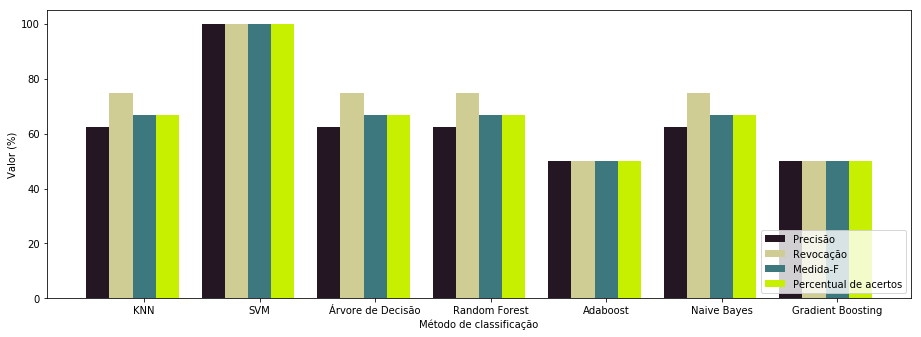

In [8]:
# Separando em treino e teste

video_groupper_test = []

test_indexes = ~train_indexes
X_train = []
X_test = []
y_train = []


for i, t in enumerate(np.array(v_embedded_nn4)[train_indexes]):
    X_train += t.tolist()
    y_train += np.full(len(t),y[train_indexes][i]).tolist()

for i, t in enumerate(np.array(v_embedded_nn4)[test_indexes]):
    X_test += t.tolist()
    video_groupper_test += np.full(len(t), i).tolist()

#Reordenar aleatoriamente o conjunto treino    
c = list(zip(X_train, y_train))
np.random.shuffle(c)
X_train, y_train = zip(*c)
    
    
# X_train = embedded_nn4[train_indexes]
# X_test = embedded_nn4[test_indexes]
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = y[test_indexes]


classify_and_report('NN4 Small 1')

### Classificações Inception Resnet V1

y_naive_bayes =  [2 3 3 1]
y_xgboost =  [2 3 3 1]
KNN

              precision    recall  f1-score   support

     Pessoa1       0.00      0.00      0.00         1
     Pessoa2       1.00      1.00      1.00         1
     Pessoa3       0.00      0.00      0.00         1
     Pessoa5       0.50      1.00      0.67         1

   micro avg       0.50      0.50      0.50         4
   macro avg       0.38      0.50      0.42         4
weighted avg       0.38      0.50      0.42         4

SVM

              precision    recall  f1-score   support

     Pessoa1       0.00      0.00      0.00         1
     Pessoa2       1.00      1.00      1.00         1
     Pessoa3       1.00      1.00      1.00         1
     Pessoa5       0.50      1.00      0.67         1

   micro avg       0.75      0.75      0.75         4
   macro avg       0.62      0.75      0.67         4
weighted avg       0.62      0.75      0.67         4

Decision Tree

              precision    recall  f1-score   support



/home/italo/eFaceRecon/env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/italo/eFaceRecon/env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/italo/eFaceRecon/env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


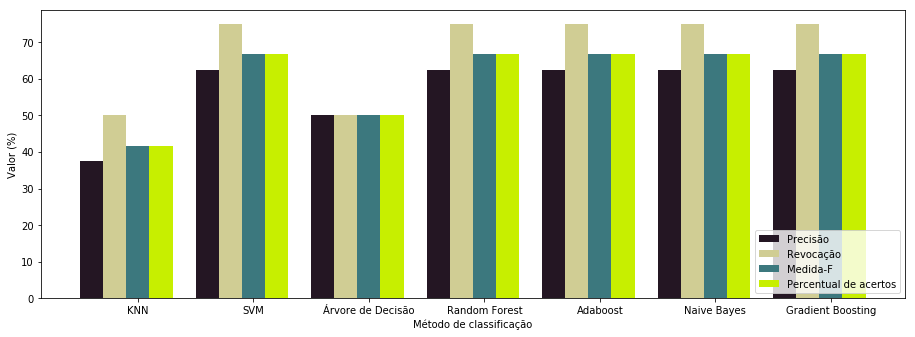

In [9]:
# Separando em treino e teste

video_groupper_test = []

test_indexes = ~train_indexes
X_train = []
X_test = []
y_train = []


for i, t in enumerate(np.array(v_embedded_facenet)[train_indexes]):
    X_train += t.tolist()
    y_train += np.full(len(t),y[train_indexes][i]).tolist()

for i, t in enumerate(np.array(v_embedded_facenet)[test_indexes]):
    X_test += t.tolist()
    video_groupper_test += np.full(len(t), i).tolist()

#Reordenar aleatoriamente o conjunto treino    
c = list(zip(X_train, y_train))
np.random.shuffle(c)
X_train, y_train = zip(*c)
    
    
# X_train = embedded_nn4[train_indexes]
# X_test = embedded_nn4[test_indexes]
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = y[test_indexes]

classify_and_report('Inception Resnet V1')

### Classificações VGG Faces

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
y_naive_bayes =  [2 3 0 1]
y_xgboost =  [2 3 0 1]
KNN

              precision    recall  f1-score   support

     Pessoa1       1.00      1.00      1.00         1
     Pessoa2       1.00      1.00      1.00         1
     Pessoa3       1.00      1.00      1.00         1
     Pessoa5       1.00      1.00      1.00         1

   micro avg       1.00      1.00      1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4

SVM

              precision    recall  f1-score   support

     Pessoa1       0.00      0.00      0.00         1
     Pessoa2       0.25      1.00      0.40         1
     Pessoa3       0.00      0.00  

/home/italo/eFaceRecon/env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/italo/eFaceRecon/env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/italo/eFaceRecon/env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


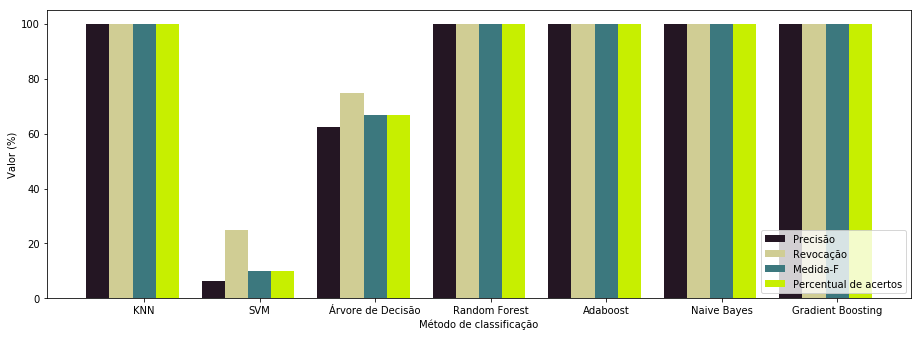

In [10]:
# Separando em treino e teste

video_groupper_test = []

test_indexes = ~train_indexes
X_train = []
X_test = []
y_train = []


for i, t in enumerate(np.array(v_embedded_vgg)[train_indexes]):
    X_train += t.tolist()
    y_train += np.full(len(t),y[train_indexes][i]).tolist()

for i, t in enumerate(np.array(v_embedded_vgg)[test_indexes]):
    X_test += t.tolist()
    video_groupper_test += np.full(len(t), i).tolist()

#Reordenar aleatoriamente o conjunto treino    
c = list(zip(X_train, y_train))
np.random.shuffle(c)
X_train, y_train = zip(*c)
    
    
# X_train = embedded_nn4[train_indexes]
# X_test = embedded_nn4[test_indexes]
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = y[test_indexes]

print(video_groupper_test)
classify_and_report('VGG Faces')

### Gravar resultados em arquivo

In [11]:
file_output = open("results/classificacao_ufla_v2v.csv", 'w')
file_output.write(class_result)
file_output.close()

## Verificação Facial TODO

### Separar as imagens em pares

In [12]:
np.random.seed(30)
names = np.unique([v.name for v in videos_mt])
pares = []
videos_restantes = []
for name in names:
    videos_pessoa = [v for v in videos_mt if v.name == name]
    if name != names[2]:
        videos_pessoa_iguais = videos_pessoa[0:2]
        videos_restantes.append(videos_pessoa[2])
        np.random.shuffle(videos_pessoa_iguais)
        pares += [[videos_pessoa_iguais[0], videos_pessoa_iguais[1]]]
    else:
        videos_restantes += videos_pessoa
np.random.shuffle(videos_restantes)
pares += [[videos_restantes[0], videos_restantes[1]]]

### Definir uma função geral de verificação

In [13]:
import matplotlib.pyplot as plt
data_for_graph = None

# Para plotar o gráfico
# data_for_graph[0] = precisão
# data_for_graph[1] = revocação
# data_for_graph[2] = medida-F
# data_for_graph[3] = percentual de erros


# string para gravar os resultados de classificação em csv
class_result = "RNC;Cálculo da distância;Limítrofe;Precisão (%);Revocação (%);Medida-F (%);Percentual de acertos\n"

# redefinição da função de escrever resultados
def write_results(y_true, y_pred, distance_calc, threshold, neural_net):
    global class_result
    global data_for_graph
    precisao = precision_score(y_true, y_pred, average='macro') * 100.0
    data_for_graph[0].append(precisao)
    revocacao = recall_score(y_true, y_pred, average='macro') * 100.0
    data_for_graph[1].append(revocacao)
    medida_f = f1_score(y_true, y_pred, average='macro') * 100.0
    data_for_graph[2].append(medida_f)
    percentual_acertos = accuracy_score(y_true, y_pred) * 100.0
    data_for_graph[3].append(percentual_acertos)
    class_result += neural_net + ";" + distance_calc + ";" + threshold + ";" + format_float(precisao) + ";" + \
                    format_float(revocacao) + ";" + format_float(medida_f) + ";" + \
                    format_float(percentual_acertos) + "\n" 


def verification_test(network, dist_function, threshold):
    y_pred = []
    y_true = []
    d_name = 'Euclideana'
    if dist_function == dist_cos:
        d_name = "Cosseno"
    network_name = 'NN4 Small 1'
    if network == 'facenet':
        network_name = 'Inception Resnet V1'
    elif network == 'vgg':
        network_name = 'VGG Faces'
    for p in pares:
        p1_frames = p[0].load_embedded(network)
        p2_frames = p[1].load_embedded(network)
        if p[0].name == p[1].name:
            y_true.append(1)
        else:
            y_true.append(0)
        y_pred_subtotal = []
        for p1, p2 in zip(p1_frames, p2_frames):
            if(dist_function(p1,p2) > threshold):
                y_pred_subtotal.append(0)
            else:
                y_pred_subtotal.append(1)
        y_pred.append(mode(y_pred_subtotal).mode[0])
    
    write_results(y_true, y_pred, d_name, str(threshold), network_name)

### Testes para NN4 Small 1

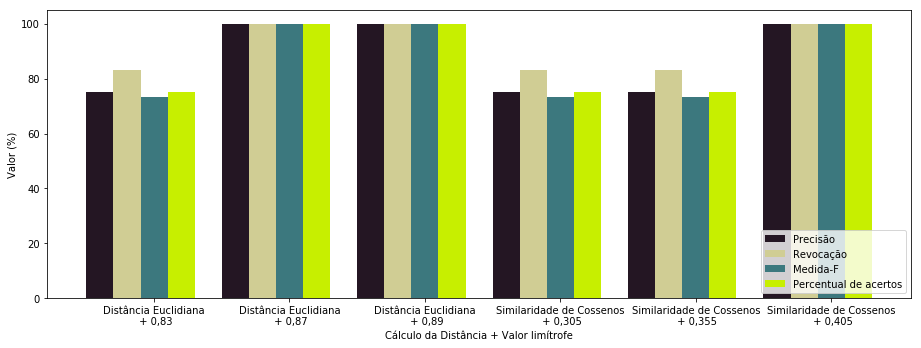

In [14]:
position_graphic = np.arange(6)
fig = plt.figure()
ax = fig.add_axes([0,0,2,1])

data_for_graph = [[],[],[],[]]
verification_test('nn4', dist_eucl, 0.83)
verification_test('nn4', dist_eucl, 0.87)
verification_test('nn4', dist_eucl, 0.89)
verification_test('nn4', dist_cos, 0.305)
verification_test('nn4', dist_cos, 0.355)
verification_test('nn4', dist_cos, 0.405)

rects1 = ax.bar(position_graphic - 0.40, data_for_graph[0], color = '#241623', width = 0.20)
rects2 = ax.bar(position_graphic - 0.20, data_for_graph[1], color = '#D0CD94', width = 0.20)
rects3 = ax.bar(position_graphic, data_for_graph[2], color = '#3C787E', width = 0.20)
rects4 = ax.bar(position_graphic + 0.20, data_for_graph[3], color = '#C7EF00', width = 0.20)
ax.legend(labels=['Precisão', 'Revocação', 'Medida-F', 'Percentual de acertos'], loc='lower right')
ax.set_xticklabels(['', "Distância Euclidiana\n + 0,83", "Distância Euclidiana\n + 0,87", "Distância Euclidiana\n + 0,89", "Similaridade de Cossenos\n + 0,305", "Similaridade de Cossenos\n + 0,355", "Similaridade de Cossenos\n + 0,405"])
ax.set_ylabel('Valor (%)')
ax.set_xlabel('Cálculo da Distância + Valor limítrofe')
plt.savefig('results/ufla V2V nn4 verificacao.pdf', format='pdf', bbox_inches='tight')

### Testes para Inception Resnet V1

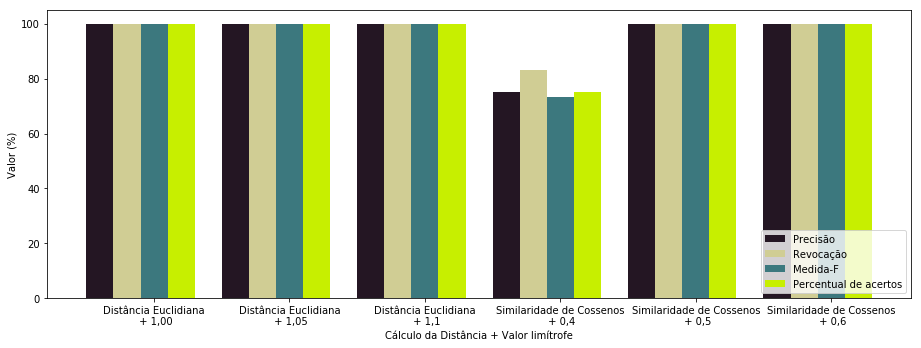

In [15]:
position_graphic = np.arange(6)
fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
data_for_graph = [[],[],[],[]]

verification_test('facenet', dist_eucl, 1.0)
verification_test('facenet', dist_eucl, 1.05)
verification_test('facenet', dist_eucl, 1.1)
verification_test('facenet', dist_cos, 0.4)
verification_test('facenet', dist_cos, 0.5)
verification_test('facenet', dist_cos, 0.6)

rects1 = ax.bar(position_graphic - 0.40, data_for_graph[0], color = '#241623', width = 0.20)
rects2 = ax.bar(position_graphic - 0.20, data_for_graph[1], color = '#D0CD94', width = 0.20)
rects3 = ax.bar(position_graphic, data_for_graph[2], color = '#3C787E', width = 0.20)
rects4 = ax.bar(position_graphic + 0.20, data_for_graph[3], color = '#C7EF00', width = 0.20)
ax.legend(labels=['Precisão', 'Revocação', 'Medida-F', 'Percentual de acertos'], loc='lower right')
ax.set_xticklabels(['', "Distância Euclidiana\n + 1,00", "Distância Euclidiana\n + 1,05", "Distância Euclidiana\n + 1,1", "Similaridade de Cossenos\n + 0,4", "Similaridade de Cossenos\n + 0,5", "Similaridade de Cossenos\n + 0,6"])
ax.set_ylabel('Valor (%)')
ax.set_xlabel('Cálculo da Distância + Valor limítrofe')
plt.savefig('results/ufla V2V inception verificacao.pdf', format='pdf', bbox_inches='tight')

### Testes para VGG Faces

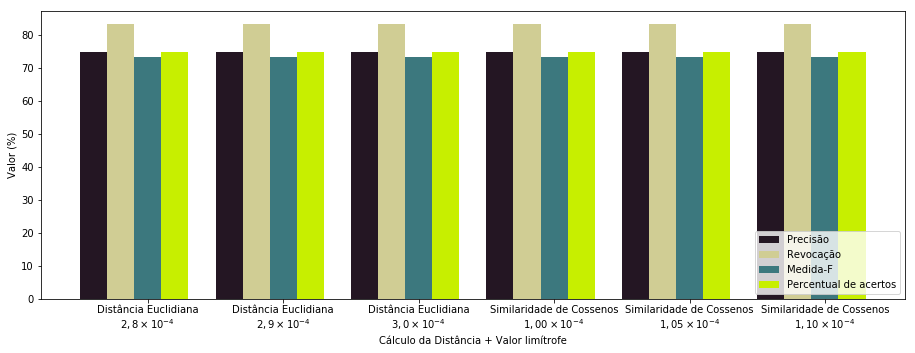

In [16]:
position_graphic = np.arange(6)
fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
data_for_graph = [[],[],[],[]]

verification_test('vgg', dist_eucl, 0.00028)
verification_test('vgg', dist_eucl, 0.00029)
verification_test('vgg', dist_eucl, 0.00030)
verification_test('vgg', dist_cos, 0.000100)
verification_test('vgg', dist_cos, 0.000105)
verification_test('vgg', dist_cos, 0.000110)

rects1 = ax.bar(position_graphic - 0.40, data_for_graph[0], color = '#241623', width = 0.20)
rects2 = ax.bar(position_graphic - 0.20, data_for_graph[1], color = '#D0CD94', width = 0.20)
rects3 = ax.bar(position_graphic, data_for_graph[2], color = '#3C787E', width = 0.20)
rects4 = ax.bar(position_graphic + 0.20, data_for_graph[3], color = '#C7EF00', width = 0.20)
ax.legend(labels=['Precisão', 'Revocação', 'Medida-F', 'Percentual de acertos'], loc='lower right')
ax.set_xticklabels(['', "Distância Euclidiana\n"+ r"$2,8\times10^{-4}$", "Distância Euclidiana\n"+ r"$2,9\times10^{-4}$", "Distância Euclidiana\n"+ r"$3,0\times10^{-4}$", "Similaridade de Cossenos\n"+ r"$1,00\times10^{-4}$", "Similaridade de Cossenos\n"+ r"$1,05\times10^{-4}$", "Similaridade de Cossenos\n"+ r"$1,10\times10^{-4}$"])
ax.set_ylabel('Valor (%)')
ax.set_xlabel('Cálculo da Distância + Valor limítrofe')
plt.savefig('results/ufla V2V vgg verificacao.pdf', format='pdf', bbox_inches='tight')

In [17]:
file_output = open("results/verificacao_ufla_v2v.csv", 'w')
file_output.write(class_result)
file_output.close()